# Tensorflow 2.0 Algos

The main goal here is to cover off on some core machine learning algos.  Apply each algo to a problem and dataset.

## What Algos?

The main ones right now for this notebook are 

* Linear Regression
* Classification
* Clustering
* Hidden Markov Models


### Google Collab Tip

If using Google Collab then run 

"%tensorflow_version 2.x  # this line is not required unless you are in a notebook" 

Restart runtime if a different version is selected.


## Linear Regression

Very basic form of machine learning used to predict numeric values.  With the magic of linear algebra this is super easy for computers to compute.

Using the Titanic dataset and the documentation from <https://www.tensorflow.org/tutorials/estimator/linear>

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from six.moves import urllib

## Loading the Dataset

This will be used to predict the survival rate of the passengers for gender, age, class, etc.

In [2]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf  
print(tf.version)  # make sure the version is 2.x

<module 'tensorflow._api.v2.version' from 'C:\\Users\\sjrus\\miniconda3\\envs\\standardenv\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [3]:
# load up the dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

In [8]:
y_train = dftrain.pop('survived')

In [11]:
y_eval = dfeval.pop('survived')

In [13]:
# explore with pandas
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [14]:
# Shape of the datasets
dftrain.shape[0], dfeval.shape[0]

(627, 264)

<AxesSubplot:>

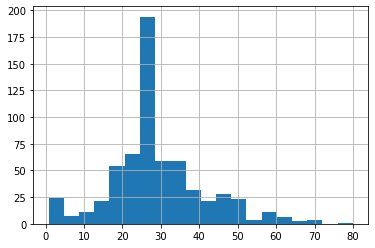

In [15]:
# histogram
dftrain.age.hist(bins=20)

<AxesSubplot:>

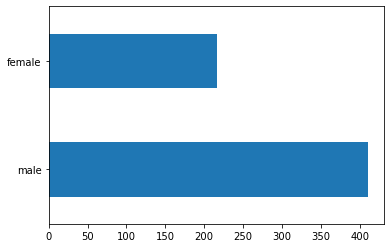

In [17]:
dftrain.sex.value_counts().plot(kind="barh")

<AxesSubplot:>

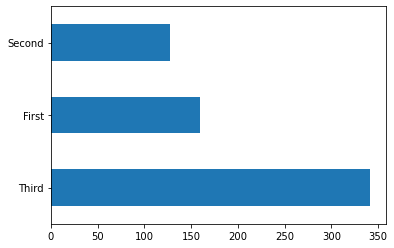

In [18]:
dftrain['class'].value_counts().plot(kind="barh")

<AxesSubplot:ylabel='sex'>

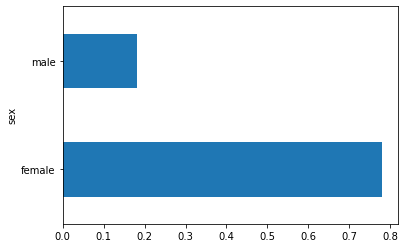

In [20]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

## Linear Regression and Feature Engineering

You need setup numeric and categorical columns differently for machine learning.  Categorical values need to converted into some type of integer encoding using the `tf.feature_column.categorical_column_with_vocabulary_list()`

For numeric columns, using the same idea but with `tf.feature_column.numeric_column()`

Read more here <https://www.tensorflow.org/api_docs/python/tf/feature_column>

In [22]:
# Gather an array of the categorial columns
CATEGORIAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

# the same for numeric
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORIAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique() # get all the unique values in the column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list=vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Creating the TF dataset

When using the TF model, the data we pass comes in as a `tf.data.Dataset` object.  Therefore, we have to convert the pandas df into that object.


In [23]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create the tf object with the data and the labels
        if shuffle:
            ds = ds.shuffle(1000) # random order
        ds = ds.batch(batch_size).repeat(num_epochs) 
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Creating the linear regression model

In [27]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\sjrus\\AppData\\Local\\Temp\\tmp0utvtxav', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.835629, 'auc_precision_recall': 0.79399896, 'average_loss': 0.48419017, 'label/mean': 0.375, 'loss': 0.47252995, 'precision': 0.66071427, 'prediction/mean': 0.43834186, 'recall': 0.74747473, 'global_step': 600}


### Creating some predictions

Use `.predict()`.  This method will return a list of dicts that store a prediction for eacch of the entries in the dataset. 

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\sjrus\AppData\Local\Temp\tmp0utvtxav\model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

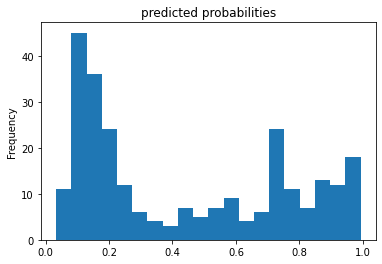

In [32]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

## Classification

Predict different labels of a dataset.  This uses the Iris dataset.

Using <https://www.tensorflow.org/tutorials/estimator/premade>


In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals

### The Dataset

There are 3 different classes:
* Setosa
* Versicolor
* Virginica

With 4 different columns for sepal/pedal with length/width

In [34]:
# Define the columns 
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [35]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0) # use the column names from before
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [36]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [37]:
# pop off the column and use as the label
train_y = train.pop("Species")
test_y = test.pop("Species")

### Input function

Just like with the other regression model from above, you have to create an input function.

In [39]:
def input_fn(features, labels, training=True, batch_size=256):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [40]:
# Doing some feature column magic

feature_columns = []
for key in train.keys():
    feature_columns.append(tf.feature_column.numeric_column(key=key))
print(feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


### Building the classifier model

There are A LOT of differnt classifier models.  Here are the two easiest ones:
* `DNNClassifier`
* `LinearClassifier`

In [42]:
# using the dnn with 2 hidden layers with 30 and 10 hidden nodes each
# the hidden number is picked arbitrattly

classifer = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[30,10],
    n_classes=3
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\sjrus\\AppData\\Local\\Temp\\tmpqzbr3b76', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [43]:
### Using Lambda as the input function

classifer.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000
)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 

In [47]:
### the model is bad... But lets evaluate the model!

eval_result = classifer.evaluate(
    input_fn=lambda: input_fn(test,test_y, training=False)
)
print('\nTest set accuracy : {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-24T08:41:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\sjrus\AppData\Local\Temp\tmpqzbr3b76\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.24095s
INFO:tensorflow:Finished evaluation at 2020-12-24-08:41:19
INFO:tensorflow:Saving dict for global step 5000: 

## Hidden Markov Model

"The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution []. Transitions among the states are governed by a set of probabilities called transition probabilities." (http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html)

Using TF to work with probabilities to predict future events or states.  

We're gonna predict the weather!
<https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel>

In [1]:
import tensorflow_probability as tfp 

In [5]:
tfd = tfp.distributions

# Creating a simple weather model

# Represents a cold day with 0 and a hot day with 1
# The first day of a sequence has a 0.8 chance of being cold.
# The model using categorical distribution:

initial_distribution = tfd.Categorical(probs=[0.8,0.2])

# A cold day has a 30% chance of being followed by a hot day
# and a hot day has a 20% chance of being followed by a cold day
# This is the simple model of that statement

transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                [0.2, 0.8]])

# Additionally that on each day the temperature is normally distributed with 
# a mean and std dev 0 / 5 on a cold day and mean and std dev 15 / 10 on a hot day
# Modeled like

observation_distribution = tfd.Normal(loc=[0.,15.], scale=[5.,10.])

# These distributions into a single week long model 

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7
)

model.mean()

# model.log_prob(tf.zeros(shape=[7]))

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([2.9999998, 5.9999995, 7.4999995, 8.25     , 8.625001 , 8.812501 ,
       8.90625  ], dtype=float32)>